## Import Libraries

In [2]:
import zipfile
import os
#import splitfolders
import pathlib
import glob
from pathlib import Path
import random

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import itertools

import cv2 as cv
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras import regularizers

from tensorflow.keras.callbacks import EarlyStopping

import joblib

## Extract the zip file

In [ ]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Dataset/NonsegmentedV2.zip' -d '/content/drive/MyDrive/Colab Notebooks/Dataset/PlantSeedling'

## Split the data images into train and test

In [ ]:
input_folder = "/content/drive/MyDrive/Colab Notebooks/Dataset/PlantSeedling"
print('Length of data images:' , len(list(pathlib.Path(input_folder).glob('*/*.png'))))

Length of data images: 5539


In [ ]:
os.listdir(pathlib.Path(input_folder)) 

['Shepherd’s Purse',
 'Small-flowered Cranesbill',
 'Fat Hen',
 'Scentless Mayweed',
 'Sugar beet',
 'Maize',
 'Loose Silky-bent',
 'Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat']

The project uses 5539 image datasets that has 12 subdirectories

Since the data is not yet split into train and test, we will going to split it accordingly

In [ ]:
output = "/content/drive/MyDrive/Colab Notebooks/Dataset/PlantSeedlingClassification" 

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.8,0.2))

Copying files: 5539 files [01:24, 65.53 files/s]


In [ ]:
output = "/content/drive/MyDrive/Colab Notebooks/Dataset/PlantSeedlingClassification" 
os.listdir(pathlib.Path(output)) 

['train', 'val']

In [ ]:
train_dir = glob.glob(output +'/train/*/*.png')
test_dir = glob.glob(output +'/val/*/*.png')

In [ ]:
print('Length of training data:' , len(train_dir))
print('Length of testing data:' , len(test_dir))

Length of training data: 4426
Length of testing data: 1113


In [ ]:
os.listdir(pathlib.Path(output+'/val')) 

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherd’s Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

All the expected plant seedlings types are present for both train and test data

## Exploratory Data Analysis

In [ ]:
train_image = []
train_label = []

for img in train_dir:
    train_image.append(cv.resize(cv.imread(img), (120, 120)))
    train_label.append(img.split('/')[-2])
image = np.asarray(train_image)
label = pd.DataFrame(train_label)

In [ ]:
image

array([[[[ 51,  79,  99],
         [ 71,  93, 114],
         [ 62,  80, 103],
         ...,
         [195, 188, 184],
         [192, 184, 181],
         [188, 181, 180]],

        [[ 66,  93, 111],
         [ 54,  79, 101],
         [ 60,  80, 102],
         ...,
         [191, 185, 181],
         [189, 183, 179],
         [187, 180, 178]],

        [[ 67,  90, 111],
         [ 68,  87, 108],
         [ 55,  74,  98],
         ...,
         [188, 181, 175],
         [186, 179, 175],
         [184, 175, 173]],

        ...,

        [[ 39,  55,  72],
         [ 30,  40,  57],
         [ 30,  33,  53],
         ...,
         [153, 152, 157],
         [161, 165, 168],
         [154, 160, 165]],

        [[ 30,  40,  55],
         [ 34,  40,  54],
         [ 31,  36,  50],
         ...,
         [143, 140, 150],
         [161, 164, 169],
         [148, 151, 161]],

        [[ 31,  35,  51],
         [ 32,  37,  51],
         [ 32,  38,  52],
         ...,
         [152, 149, 155],
        

In [ ]:
label

,0
0,Black-grass
1,Black-grass
2,Black-grass
3,Black-grass
4,Black-grass
...,...
4421,Sugar beet
4422,Sugar beet
4423,Sugar beet
4424,Sugar beet


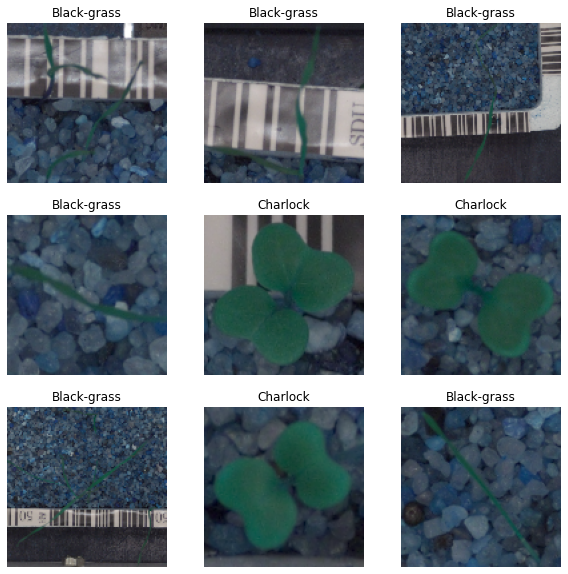

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  y = random.randrange(100,500)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[y])
  plt.title(label.iloc[y,0])
  plt.axis("off")

Text(0.5, 1.0, 'Count per plant seedling species')

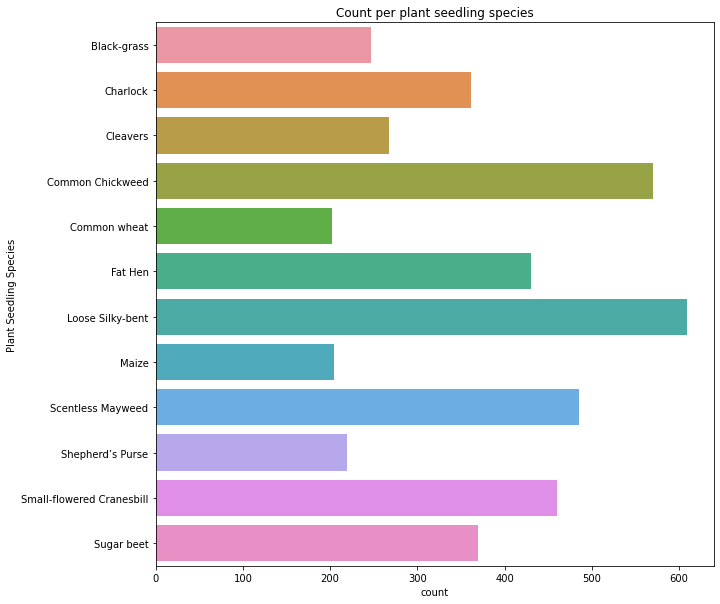

In [ ]:
plt.figure(figsize=(10, 10))
sns.countplot(y=label[0])
plt.ylabel('Plant Seedling Species')
plt.title('Count per plant seedling species')

In [ ]:
label[0].value_counts()

Loose Silky-bent             609
Common Chickweed             570
Scentless Mayweed            485
Small-flowered Cranesbill    460
Fat Hen                      430
Sugar beet                   370
Charlock                     361
Cleavers                     268
Black-grass                  247
Shepherd’s Purse             219
Maize                        205
Common wheat                 202
Name: 0, dtype: int64

## Data Preprocessing

**Encode categorical labels to numerical**

In [ ]:
encoder = LabelEncoder()
encoder.fit(label[0])
encoded_labels = encoder.transform(label[0])
labels = np_utils.to_categorical(encoded_labels)

**Split the dataset into X and Y**

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(image,labels,test_size=0.2,random_state=7)

**Normalization of the images**

In [ ]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255 

**Initialize the images using Data Generator**

In [ ]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         zoom_range=[0.4,1.5],
                                                         horizontal_flip=True,
                                                         vertical_flip=True)

datagen.fit(X_train)

**Create function for future use**

In [ ]:
def preprocess(images, label):
  encoder = LabelEncoder()
  encoder.fit(label[0])
  encoded_labels = encoder.transform(label[0])
  labels = np_utils.to_categorical(encoded_labels)

  X_train,X_test,y_train,y_test=train_test_split(images,labels,test_size=0.2,random_state=7)
  X_train = X_train.astype('float32') / 255
  X_test = X_test.astype('float32') / 255 

  datagen.fit(X_train)

  return X_train, X_test, y_train, y_test

## Model Development

In [ ]:
input_shape = (120,120,3)
num_classes = len(labels)
epochs = 100
batch_size =32
lr = 0.001

In [ ]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Model 1: CNN model using Tensorflow and Keras**

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same', activation = 'relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(64, kernel_size=(3, 3), padding='same',activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(64, (3, 3),activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(128, kernel_size=(3, 3), padding='same',activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(128, (3, 3),activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(256,activation='relu'))
model1.add(Dense(12,activation='softmax'))

model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 120, 120, 32)      896       
                                                                 
 batch_normalization_30 (Bat  (None, 120, 120, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_49 (Conv2D)          (None, 118, 118, 32)      9248      
                                                                 
 batch_normalization_31 (Bat  (None, 118, 118, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 59, 59, 32)       0         
 g2D)                                                            
                                                      

In [ ]:
model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/100
111/111 [==============================] - 7s 55ms/step - loss: 4.3522 - accuracy: 0.4260 - val_loss: 14.4350 - val_accuracy: 0.1411
Epoch 2/100
111/111 [==============================] - 6s 51ms/step - loss: 0.8851 - accuracy: 0.7158 - val_loss: 8.6180 - val_accuracy: 0.1490
Epoch 3/100
111/111 [==============================] - 6s 51ms/step - loss: 0.6413 - accuracy: 0.8082 - val_loss: 14.4092 - val_accuracy: 0.1388
Epoch 4/100
111/111 [==============================] - 6s 52ms/step - loss: 0.4136 - accuracy: 0.8658 - val_loss: 5.9287 - val_accuracy: 0.3070
Epoch 5/100
111/111 [==============================] - 6s 53ms/step - loss: 0.3086 - accuracy: 0.8969 - val_loss: 1.9962 - val_accuracy: 0.5903
Epoch 6/100
111/111 [==============================] - 6s 52ms/step - loss: 0.2434 - accuracy: 0.9220 - val_loss: 1.7148 - val_accuracy: 0.6050
Epoch 7/100
111/111 [==============================] - 6s 53ms/step - loss: 0.2163 - accuracy: 0.9254 - val_loss: 1.1278 - val_accurac

Text(0.5, 1.0, 'Training and Validation Accuracy')

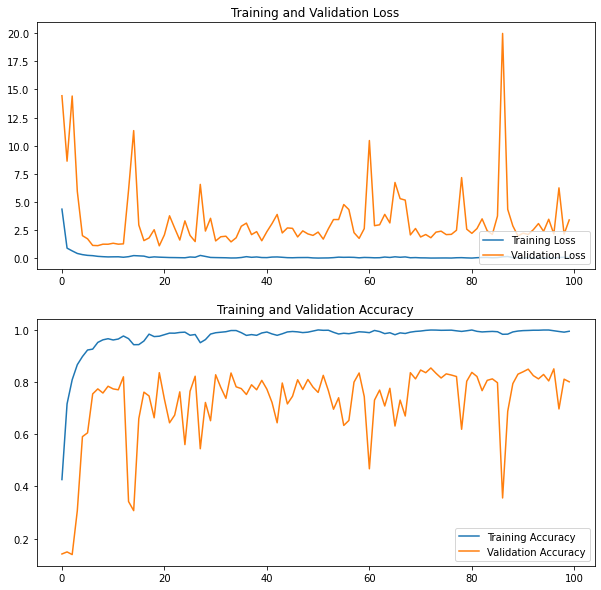

In [ ]:
# Accuracy and Loss per epoch
df_result_1 = pd.DataFrame(model1.history.history)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(df_result_1[['loss']], label='Training Loss')
plt.plot(df_result_1[['val_loss']], label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(df_result_1[['accuracy']], label='Training Accuracy')
plt.plot(df_result_1[['val_accuracy']], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Training Accuracy: 0.9715
Training Loss: 0.0971
Testing Accuracy:  0.7912
Testing Loss:  1.3652


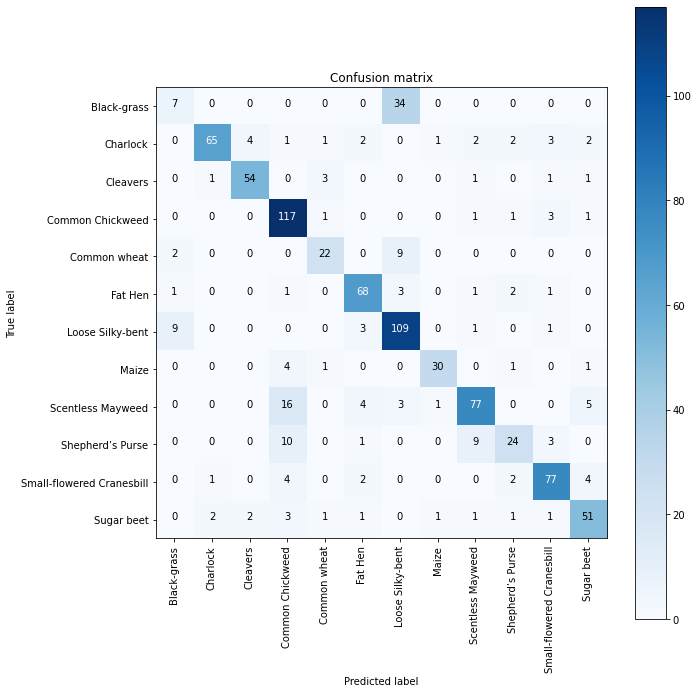

In [ ]:
# Overall Loss and Accuracy of the model
loss, accuracy = model1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

# Prediction and Confusion Matrix
y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

cm = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(cm, classes = encoder.classes_) 

In [ ]:
joblib.dump(model1,'cnn_model_1.pkl')

['cnn_model_1.pkl']

Result of model 1

**Model 2: Adding early stopping as callback**

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same', activation = 'relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(64, kernel_size=(3, 3), padding='same',activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(64, (3, 3),activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(128, kernel_size=(3, 3), padding='same',activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(128, (3, 3),activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(256,activation='relu'))
model1.add(Dense(12,activation='softmax'))

model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 120, 120, 32)      896       
                                                                 
 batch_normalization_36 (Bat  (None, 120, 120, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_55 (Conv2D)          (None, 118, 118, 32)      9248      
                                                                 
 batch_normalization_37 (Bat  (None, 118, 118, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 59, 59, 32)       0         
 g2D)                                                            
                                                      

In [ ]:
model2 = model1

In [ ]:
model2.fit(X_train, y_train, 
           epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/100
111/111 [==============================] - 7s 57ms/step - loss: 3.2634 - accuracy: 0.4605 - val_loss: 6.9398 - val_accuracy: 0.1388
Epoch 2/100
111/111 [==============================] - 6s 54ms/step - loss: 0.8966 - accuracy: 0.7090 - val_loss: 11.7279 - val_accuracy: 0.1400
Epoch 3/100
111/111 [==============================] - 6s 55ms/step - loss: 0.5666 - accuracy: 0.8158 - val_loss: 13.1595 - val_accuracy: 0.1185
Epoch 4/100
111/111 [==============================] - 6s 54ms/step - loss: 0.3898 - accuracy: 0.8630 - val_loss: 6.4201 - val_accuracy: 0.2449
Epoch 5/100
111/111 [==============================] - 6s 54ms/step - loss: 0.3296 - accuracy: 0.8918 - val_loss: 1.7057 - val_accuracy: 0.5948
Epoch 6/100
111/111 [==============================] - 6s 55ms/step - loss: 0.2810 - accuracy: 0.9020 - val_loss: 2.4424 - val_accuracy: 0.5745
Epoch 7/100
111/111 [==============================] - 7s 59ms/step - loss: 0.2093 - accuracy: 0.9319 - val_loss: 0.9062 - val_accurac

Text(0.5, 1.0, 'Training and Validation Accuracy')

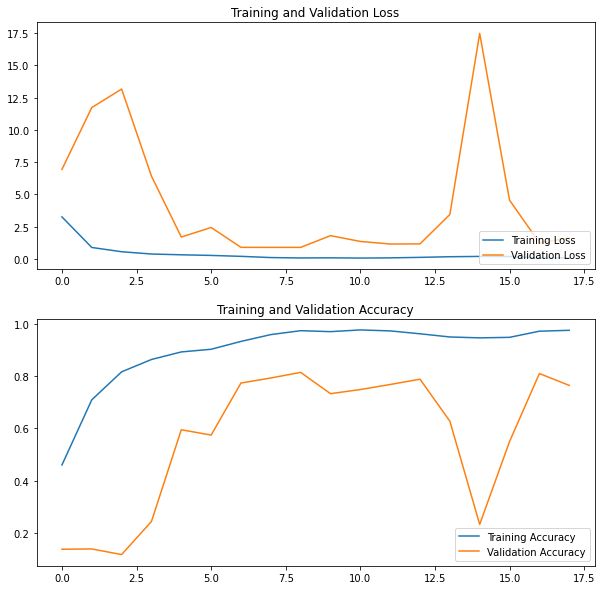

In [ ]:
# Accuracy and Loss per epoch
df_result_2 = pd.DataFrame(model2.history.history)
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(df_result_2[['loss']], label='Training Loss')
plt.plot(df_result_2[['val_loss']], label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.subplot(2, 1, 2)
plt.plot(df_result_2[['accuracy']], label='Training Accuracy')
plt.plot(df_result_2[['val_accuracy']], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Training Accuracy: 0.9715
Training Loss: 0.0971
Testing Accuracy:  0.7912
Testing Loss: 1.3652


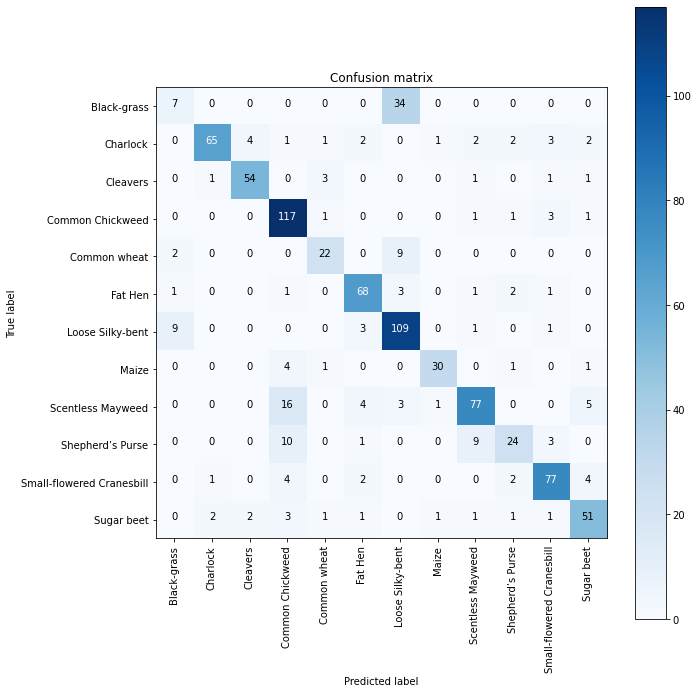

In [ ]:
# Overall Loss and Accuracy of the model
loss, accuracy = model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss, accuracy = model2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss: {:.4f}".format(loss))

# Prediction and Confusion Matrix
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

cm = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(cm, classes = encoder.classes_) 

In [ ]:
joblib.dump(model2,'cnn_model_2.pkl')

['cnn_model_2.pkl']

**Model 3: Adding Dropouts**

In [ ]:
model3 = Sequential()

model3.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same', activation = 'relu'))
model3.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.50))

model3.add(Conv2D(64, kernel_size=(3, 3), padding='same',activation='relu'))
model3.add(Conv2D(64, (3, 3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.50))

model3.add(Conv2D(128, kernel_size=(3, 3), padding='same',activation='relu'))
model3.add(Conv2D(128, (3, 3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.50))

model3.add(Flatten())
model3.add(Dense(256,activation='relu'))
model3.add(Dropout(0.50))
model3.add(Dense(12,activation='softmax'))

model3.summary()

model3.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 120, 120, 32)      896       
                                                                 
 conv2d_91 (Conv2D)          (None, 118, 118, 32)      9248      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 59, 59, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 59, 59, 32)        0         
                                                                 
 conv2d_92 (Conv2D)          (None, 59, 59, 64)        18496     
                                                                 
 conv2d_93 (Conv2D)          (None, 57, 57, 64)        36928     
                                                     

In [ ]:
model3.fit(X_train, y_train, 
           epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/100
111/111 [==============================] - 6s 49ms/step - loss: 2.3528 - accuracy: 0.1853 - val_loss: 1.8550 - val_accuracy: 0.4029
Epoch 2/100
111/111 [==============================] - 5s 45ms/step - loss: 1.7611 - accuracy: 0.4014 - val_loss: 1.4519 - val_accuracy: 0.5587
Epoch 3/100
111/111 [==============================] - 5s 45ms/step - loss: 1.4030 - accuracy: 0.5266 - val_loss: 1.0602 - val_accuracy: 0.6693
Epoch 4/100
111/111 [==============================] - 5s 46ms/step - loss: 1.1402 - accuracy: 0.6020 - val_loss: 0.8496 - val_accuracy: 0.7314
Epoch 5/100
111/111 [==============================] - 5s 46ms/step - loss: 0.9728 - accuracy: 0.6644 - val_loss: 0.8659 - val_accuracy: 0.7302
Epoch 6/100
111/111 [==============================] - 5s 46ms/step - loss: 0.8946 - accuracy: 0.6794 - val_loss: 0.8280 - val_accuracy: 0.7257
Epoch 7/100
111/111 [==============================] - 5s 46ms/step - loss: 0.8182 - accuracy: 0.7130 - val_loss: 0.7324 - val_accuracy:

Text(0.5, 1.0, 'Training and Validation Accuracy')

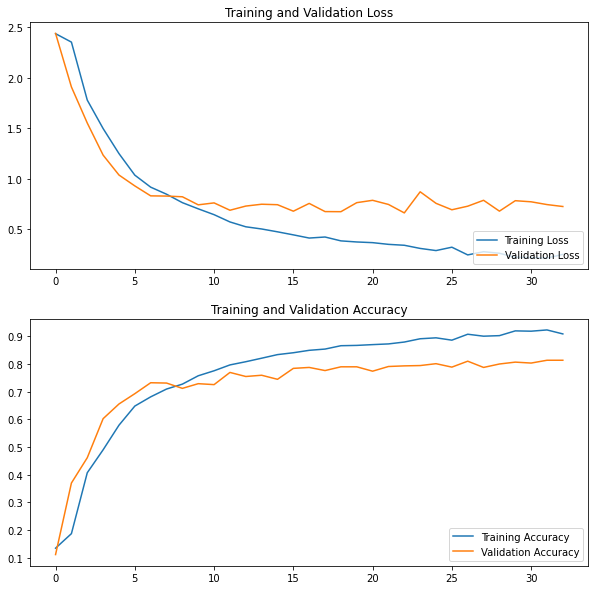

In [ ]:
df_result_3 = pd.DataFrame(model3.history.history)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(df_result_3[['loss']], label='Training Loss')
plt.plot(df_result_3[['val_loss']], label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(df_result_3[['accuracy']], label='Training Accuracy')
plt.plot(df_result_3[['val_accuracy']], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
joblib.dump(model3,'cnn_model_3.pkl')

['cnn_model_3.pkl']

Training Accuracy: 0.9893
Training Loss: 0.0396
Testing Accuracy:  0.8420
Testing Loss: 0.6753


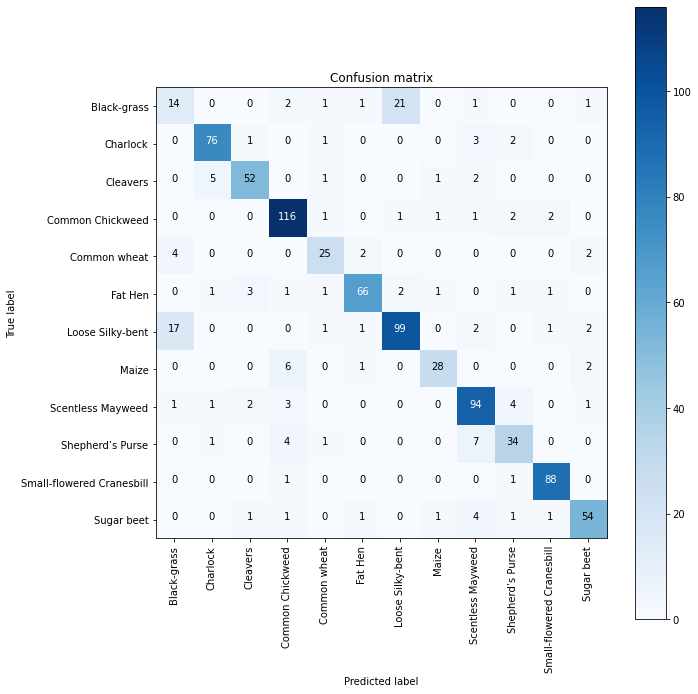

In [ ]:
# Overall Loss and Accuracy of the model
loss, accuracy = model3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss, accuracy = model3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss: {:.4f}".format(loss))

# Prediction and Confusion Matrix
y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

cm = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(cm, classes = encoder.classes_) 

**Final Evaluation**
- Model 3 has the highest training and testing accuracy among the three models
- Model 3 also has the lowest training and testing loss amoong the three models
- Adding Dropouts and callbacks to the model were able to improve the performance of the models

## Test the model using images

In [3]:
import joblib
best_model_dir = '/content/drive/MyDrive/Colab Notebooks/PlantSeedlingClassification/Model/cnn_model_3.pkl'

In [9]:
model = joblib.load(best_model_dir)

In [5]:
sample_image = '/content/drive/MyDrive/Colab Notebooks/Dataset/PlantSeedlingClassification/val/Common Chickweed/104.png'

In [16]:
def preprocess_data(img):
  img = cv.resize(cv.imread(img), (120, 120))
  img = np.asarray(img)
  img = img.astype('float32') / 255
  return img.reshape(-1, 120, 120, 3)

def prediction(model,image,labels):
  pred_class = model.predict(image)[0]
  pred_class_np = np.argmax(pred_class, axis=-1) 
  label = labels[pred_class_np]
  score = max(pred_class)*100
  return label, score     

In [7]:
  labels = ['Black-grass','Charlock','Cleavers','Common Chickweed','Common wheat',
                 'Fat Hen','Loose Silky-bent','Maize','Scentless Mayweed','Shepherd’s Purse',
                 'Small-flowered Cranesbill','Sugar beet']

In [19]:
predicted_label, predicted_score = prediction(model, preprocess_data(sample_image),labels)
print("The image is classified as",predicted_label, "with a similarity score of",predicted_score)

The image is classified as Common Chickweed with a similarity score of 100.0
